Use LSTM to train AAPL 

In [1]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install pyodbc


Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib. pyplot as plt
import matplotlib
import pyodbc
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib. dates as mandates
from sklearn import linear_model

from keras. layers import LSTM, Dense, Dropout
from keras. models import Sequential
from keras. layers import Dense
import keras. backend as K
from keras. callbacks import EarlyStopping
from keras. models import load_model
from keras. layers import LSTM
from keras. utils.vis_utils import plot_model
from keras.optimizers import Adam


C:\Users\Evelyn\AppData\Local\Temp\ipykernel_20880\555286768.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [7]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install Keras


Note: you may need to restart the kernel to use updated packages.


In [9]:
#get the view table from SQL
# Define the connection details
server = 'stocksserver.database.windows.net' 
database = 'stockdb' 
username = 'Evelyn'
password = 'Apple2327'

# Establish the connection
conn = pyodbc.connect('DRIVER={SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
query_price = "SELECT * FROM Daily_Price;"
# Execute the query and create a DataFrame
clean_df = pd.read_sql(query_price, conn)

# Don't forget to close the connection when done
conn.close()






C:\Users\Evelyn\AppData\Local\Temp\ipykernel_20880\4071412966.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  clean_df = pd.read_sql(query_price, conn)


In [10]:
clean_df

,Ticker,Date,Open_Price,High_Price,Low_Price,Close_Price,Volume
0,AAL,2005-10-07,20.90,23.00,20.90,22.15,16350134
1,AAL,2005-10-14,22.28,22.40,21.40,22.27,9746113
2,AAL,2005-10-21,22.15,22.42,20.85,21.96,14218231
3,AAL,2005-10-28,22.01,23.90,21.70,23.90,9263807
4,AAL,2005-11-04,24.00,29.00,24.00,28.80,16788473
...,...,...,...,...,...,...,...
45681,XOM,2024-01-12,100.73,101.29,98.16,99.95,94947905
45682,XOM,2024-01-19,99.82,100.01,95.82,96.95,79648421
45683,XOM,2024-01-26,96.70,103.08,95.77,103.00,95840552
45684,XOM,2024-02-02,102.98,104.88,101.61,101.97,101557866


In [11]:
#check null values
print('Dataframe Shape: ', clean_df. shape)

missing_values = clean_df.isna().any().any()
missing_values 

Dataframe Shape:  (45686, 7)


False

In [12]:
#adjust datetime

import datetime

def str_to_datetime(s):
    split =s.split('-')
    year,month,day=int(split[0]),int(split[1]),int(split[2])

    return datetime.datetime(year=year,month=month,day=day)




In [13]:
clean_df['Date']=clean_df['Date'].apply(str_to_datetime)
clean_df['Date']
clean_df.index=clean_df.pop('Date')

In [14]:
# Filter DataFrame for the desired symbol
AAPL_df = clean_df[clean_df['Ticker'] == 'AAPL']
AAPL_df

,Ticker,Open_Price,High_Price,Low_Price,Close_Price,Volume
Date,,,,,,
1999-11-12,AAPL,87.75,97.73,86.75,90.62,25776200
1999-11-19,AAPL,89.62,94.75,88.06,92.44,13711000
1999-11-26,AAPL,91.75,95.50,88.50,95.06,9757600
1999-12-03,AAPL,94.25,115.56,93.25,115.00,28046300
1999-12-10,AAPL,114.56,118.00,99.00,103.00,25152800
...,...,...,...,...,...,...
2024-01-05,AAPL,187.15,188.44,180.17,181.18,275083628
2024-01-12,AAPL,182.09,187.05,181.50,185.92,238385377
2024-01-19,AAPL,182.16,191.95,180.30,191.56,259829213


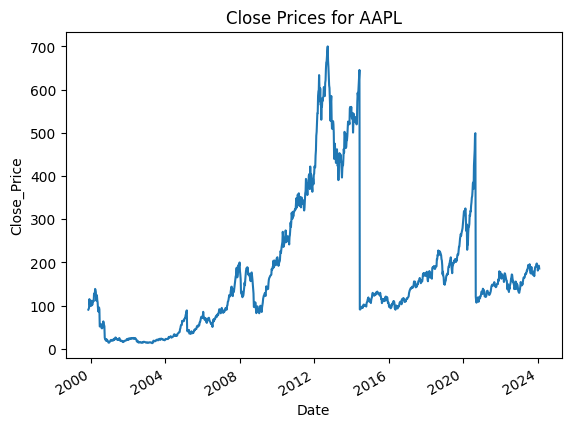

In [15]:

# Plot closing prices
AAPL_df['Close_Price'].plot()
# # Add labels and title
plt.xlabel('Date')
plt.ylabel('Close_Price')
plt.title('Close Prices for AAPL')
# Show plot
plt.show()

In [16]:
#Set Target Variable
AAPL_output = AAPL_df['Close_Price']
#Selecting the Features 
features = ['Open_Price','High_Price','Low_Price','Volume']

#Scaling
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(AAPL_df[features])
feature_transform= pd.DataFrame(columns=features, data=feature_transform, index=AAPL_df.index)
feature_transform.head()

,Open_Price,High_Price,Low_Price,Volume
Date,,,,
1999-11-12,0.108741,0.121630,0.108724,0.017455
1999-11-19,0.111466,0.117320,0.110648,0.007061
1999-11-26,0.114570,0.118405,0.111294,0.003655
1999-12-03,0.118213,0.147417,0.118270,0.019410
1999-12-10,0.147810,0.150946,0.126715,0.016918


In [17]:
 
#Splitting to Training set and Test set
timesplit= TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(feature_transform):
        X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = AAPL_output[:len(train_index)].values.ravel(), AAPL_output[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [18]:
#Process the data for LSTM
trainX =np.array(X_train)
testX =np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

In [19]:
#Building the LSTM Model
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')


In [20]:
pip install pydot

In [21]:
pip install graphviz 

Note: you may need to restart the kernel to use updated packages.


In [22]:
pip install pydot-ng

Note: you may need to restart the kernel to use updated packages.


In [23]:
plot_model(lstm, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [24]:
history=lstm.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1, shuffle=False)

Epoch 1/100
144/144 [==============================] - 1s 1ms/step - loss: 54599.7930
Epoch 2/100
144/144 [==============================] - 0s 1ms/step - loss: 54269.8320
Epoch 3/100
144/144 [==============================] - 0s 1ms/step - loss: 53624.6133
Epoch 4/100
144/144 [==============================] - 0s 1ms/step - loss: 52544.5742
Epoch 5/100
144/144 [==============================] - 0s 1ms/step - loss: 50992.8047
Epoch 6/100
144/144 [==============================] - 0s 1ms/step - loss: 49013.7930
Epoch 7/100
144/144 [==============================] - 0s 1ms/step - loss: 46697.5000
Epoch 8/100
144/144 [==============================] - 0s 1ms/step - loss: 44144.9062
Epoch 9/100
144/144 [==============================] - 0s 1ms/step - loss: 41449.1445
Epoch 10/100
144/144 [==============================] - 0s 1ms/step - loss: 38689.4648
Epoch 11/100
144/144 [==============================] - 0s 1ms/step - loss: 35930.8086
Epoch 12/100
144/144 [==============================

In [25]:
#LSTM Prediction
y_pred= lstm.predict(X_test)

4/4 [==============================] - 0s 2ms/step


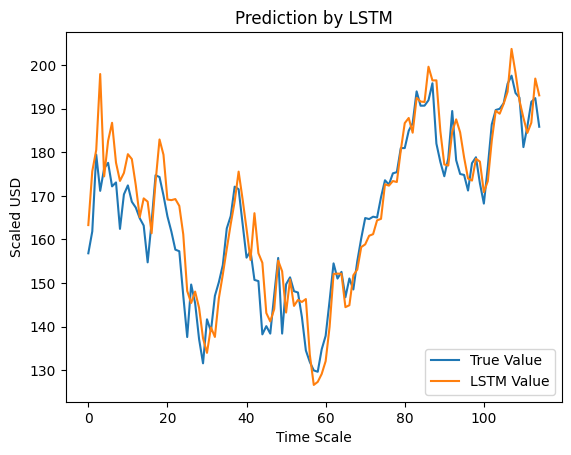

In [26]:
#Predicted vs True Adj Close Value – LSTM
plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='LSTM Value')
plt.title('Prediction by LSTM')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()

In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Performance Evaluation
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2) Score:", r2)

Mean Absolute Error (MAE): 5.048144711701767
Mean Squared Error (MSE): 44.58649850058402
Root Mean Squared Error (RMSE): 6.677312221289642
R-squared (R2) Score: 0.8591922418792073


c:\Users\Evelyn\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
